
# Movie Recommender

The used movie ratings dataset describes 5-star rating and free-text tagging activity from [MovieLens](http://movielens.org), a movie recommendation service. This and other GroupLens data sets are publicly available for download at <http://grouplens.org/datasets/>.

#### Libraries and Data

In [ ]:
pip install scikit-surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 kB 13.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp310-cp310-linux_x86_64.whl size=3163748 sha256=edc731efb2874579986b4d0689127061b3b4debd72ac421a8b4081ee49da0629
  Stored in directory: /root/.cache/pip/wheels/a5/ca/a8/4e28def53797fdc4363ca4af740db15a9c2f1595ebc51fb445
Successfully built scikit-surprise


In [ ]:
from surprise import SVD
from surprise import Dataset
from surprise.model_selection import cross_validate

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.preprocessing import PowerTransformer, StandardScaler
from sklearn import set_config
from sklearn.metrics.pairwise import cosine_similarity

from surprise import Reader, Dataset, KNNBasic, accuracy
from surprise.model_selection import train_test_split

In [ ]:
url = 'https://drive.google.com/file/d/1-S485TPxb2Nq4Bk_d1Q76A6YgOha18VK/view?usp=sharing'
path = 'https://drive.google.com/uc?id='+url.split('/')[-2]
movies = pd.read_csv(path)

url = 'https://drive.google.com/file/d/1eGHxGnxEbgVpfRDZ1q_xbGjsNd-SLAr2/view?usp=sharing'
path = 'https://drive.google.com/uc?id='+url.split('/')[-2]
links = pd.read_csv(path)

url = 'https://drive.google.com/file/d/1xKJGGKcuBSTt2_77atnlJDuZuXmzL9kV/view?usp=sharing'
path = 'https://drive.google.com/uc?id='+url.split('/')[-2]
ratings = pd.read_csv(path)

url = 'https://drive.google.com/file/d/1609rztVYG0gaz8FFrTIr9Q_nqCmlmzyp/view?usp=sharing'
path = 'https://drive.google.com/uc?id='+url.split('/')[-2]
tags = pd.read_csv(path)

___
<a id="exploration"></a>
## 1.&nbsp; Data Exploration 🔎

The dataset stems from [MovieLens](http://movielens.org), a movie recommendation service. It contains 100836 ratings and 3683 tag applications across 9742 movies. These data were created by 610 users between March 29, 1996 and September 24, 2018. This dataset was generated on September 26, 2018.

In [ ]:
movies

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy
9739,193585,Flint (2017),Drama
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation


In [ ]:
# Duplicate movie titles
movies.loc[movies["title"].duplicated(), :]

,movieId,title,genres
5601,26958,Emma (1996),Romance
6932,64997,War of the Worlds (2005),Action|Sci-Fi
9106,144606,Confessions of a Dangerous Mind (2002),Comedy|Crime|Drama|Romance|Thriller
9135,147002,Eros (2004),Drama|Romance
9468,168358,Saturn 3 (1980),Sci-Fi|Thriller


In [ ]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB


In [ ]:
print("Number of duplicates: ", movies.duplicated().sum())
print("Number of NAs: ", movies.isna().any().sum())

Number of duplicates:  0
Number of NAs:  0


___

In [ ]:
ratings

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
...,...,...,...,...
100831,610,166534,4.0,1493848402
100832,610,168248,5.0,1493850091
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352


In [ ]:
ratings["rating"].describe()

count    100836.000000
mean          3.501557
std           1.042529
min           0.500000
25%           3.000000
50%           3.500000
75%           4.000000
max           5.000000
Name: rating, dtype: float64

In [ ]:
ratings["rating"].value_counts(normalize=True).round(2)

4.0    0.27
3.0    0.20
5.0    0.13
3.5    0.13
4.5    0.08
2.0    0.07
2.5    0.06
1.0    0.03
1.5    0.02
0.5    0.01
Name: rating, dtype: float64

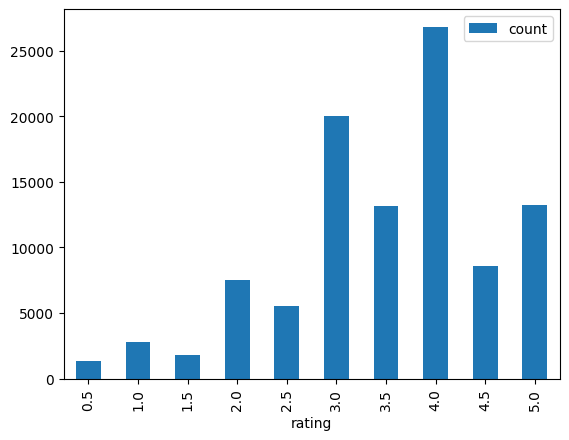

In [ ]:
plot_ratings = ratings.groupby("rating").agg(count=("rating", "count")).reset_index()
plot_ratings.plot.bar(y="count", x="rating");

In [ ]:
print("Number of duplicates: ", ratings.duplicated().sum())
print("Number of NAs: ", ratings.isna().any().sum())

Number of duplicates:  0
Number of NAs:  0


___

___
<a id="popularity"></a>
## 2.&nbsp; Popularity Recommender ⭐

We'll code a popularity-based, non-personalised recommender system that takes as an input the ratings and movies datasets and outputs the “best” movies. Those movies will appear as the top row of the WBSFLIX site.


<a id="metrics"></a>
### 2.1.&nbsp; Ratings & Popularity Metrics

In [ ]:
# Calculate popularity and movie ratings
metrics = ratings.groupby("movieId").agg({
    "rating": "mean",
    "movieId": "count"
})
metrics.columns = ['avg_rating', 'number_of_ratings']

metrics

,avg_rating,number_of_ratings
movieId,,
1,3.920930,215
2,3.431818,110
3,3.259615,52
4,2.357143,7
5,3.071429,49
...,...,...
193581,4.000000,1
193583,3.500000,1
193585,3.500000,1


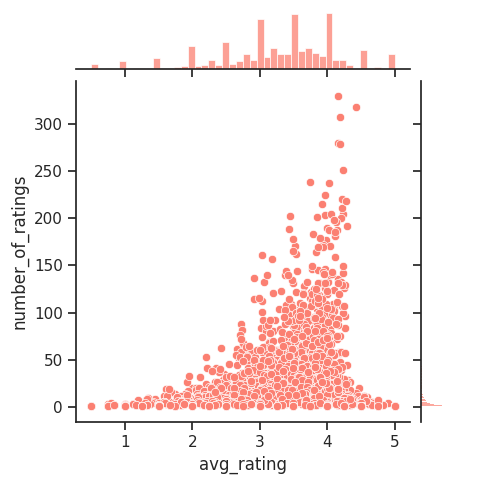

In [ ]:
sns.set_theme(style="ticks")
sns.jointplot(
    data=metrics,
    x="avg_rating", y="number_of_ratings",
    color=sns.color_palette("Set3", 6)[3], height=5);

<a id="combined"></a>
### 2.3.&nbsp; Combined Metric

Let's calculate a metric that **combines** the **average movie rating** with the **number of times** a movie was rated:

`combined_metric` = 2 * `avg_rating` + `number_of_ratings`

I'll give the average rating of a movie more weight than the number of times a movie was rated, because I believe it's a more important quality feature.

In [ ]:
metrics["combined_metric"] = (
    (2 * metrics["avg_rating"]) + (1 * metrics["number_of_ratings"]))
# The 10 best movies based on the combined metric
metrics.nlargest(10, "combined_metric")

,avg_rating,number_of_ratings,combined_metric
movieId,,,
356,4.164134,329,337.328267
318,4.429022,317,325.858044
296,4.197068,307,315.394137
593,4.161290,279,287.322581
2571,4.192446,278,286.384892
260,4.231076,251,259.462151
480,3.750000,238,245.500000
110,4.031646,237,245.063291
589,3.970982,224,231.941964


The best ranking movies that can well be recommended are the following:

In [ ]:
top10_movieIDs = metrics.reset_index().nlargest(10, "combined_metric")["movieId"]
movie_cols = ["title", "genres"]
top10_movies = movies.loc[movies["movieId"].isin(top10_movieIDs), movie_cols].drop_duplicates()
top10_movies.insert(0, column="ranking", value=range(1,11,1))

In [ ]:
top10_movies

,ranking,title,genres
97,1,Braveheart (1995),Action|Drama|War
224,2,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi
257,3,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller
277,4,"Shawshank Redemption, The (1994)",Crime|Drama
314,5,Forrest Gump (1994),Comedy|Drama|Romance|War
418,6,Jurassic Park (1993),Action|Adventure|Sci-Fi|Thriller
461,7,Schindler's List (1993),Drama|War
507,8,Terminator 2: Judgment Day (1991),Action|Sci-Fi
510,9,"Silence of the Lambs, The (1991)",Crime|Horror|Thriller
1939,10,"Matrix, The (1999)",Action|Sci-Fi|Thriller


<a id="recommender_function"></a>
### 2.4.&nbsp; Popularity Recommender Function

Let's bring it all together in a function.

In [ ]:
def recommend_most_popular_movies(
        ratings_df: pd.DataFrame,
        movies_df: pd.DataFrame,
        n_movies: int):

    print("Most popular movies:\n")

    # Popularity metrics dataframe
    metrics = ratings_df.groupby("movieId").agg({
        "rating": "mean",
        "movieId": "count"
    })
    metrics.columns = ['avg_rating', 'number_of_ratings']

    # Combined metric
    metrics["combined_metric"] = (
        (2 * metrics["avg_rating"]) + (1 * metrics["number_of_ratings"]))

    # Select most popular movies
    top_n_movie_IDs = metrics.reset_index().nlargest(n_movies, "combined_metric")["movieId"]
    movie_cols = ["title", "genres"]
    top_n_movies = movies_df.loc[movies_df["movieId"].isin(top_n_movie_IDs), movie_cols].drop_duplicates()
    top_n_movies.insert(0, column="ranking", value=range(1, n_movies+1, 1))

    return top_n_movies


In [ ]:
recommend_most_popular_movies(ratings_df=ratings, movies_df=movies, n_movies=10)

Most popular movies:



,ranking,title,genres
97,1,Braveheart (1995),Action|Drama|War
224,2,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi
257,3,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller
277,4,"Shawshank Redemption, The (1994)",Crime|Drama
314,5,Forrest Gump (1994),Comedy|Drama|Romance|War
418,6,Jurassic Park (1993),Action|Adventure|Sci-Fi|Thriller
461,7,Schindler's List (1993),Drama|War
507,8,Terminator 2: Judgment Day (1991),Action|Sci-Fi
510,9,"Silence of the Lambs, The (1991)",Crime|Horror|Thriller
1939,10,"Matrix, The (1999)",Action|Sci-Fi|Thriller


___
<a id="item"></a>
## 3.&nbsp; Item-based Recommender 🟰

An item-based similarity recommending system takes an item, in our case a movie, as an input and outputs a list of movies that are “similar” to the one inputted.

The similarity is based on rating correlations from a user-item matrix. The recommender will look at how all users rated the input movie and suggest movies that were rated similarly. This effectively does not select by genre, but rather by user preferences. If lots of users that like romantic films also like horror movies, then the recommender will mix these two genres.

In [ ]:
def recommend_similar_movies(
        ratings_df: pd.DataFrame,
        movies_df: pd.DataFrame,
        movie_id: int,
        top_n_movies: int,
        similarity_threshold: float,
        no_of_users_threshold: int):

    # Selected movie
    print("Selected movie: ", movies_df.loc[movies_df["movieId"]==movie_id, "title"][0])
    print("\nSimilar movies:\n")

    # User-item matrix
    user_movie_matrix = pd.pivot_table(
        data=ratings_df,
        values='rating',
        index='userId',
        columns='movieId',
        fill_value=0)
    # (Cosine) Similarity matrix
    movie_similarity_matrix = pd.DataFrame(
        cosine_similarity(user_movie_matrix.T),
        columns=user_movie_matrix.columns,
        index=user_movie_matrix.columns)

    # Similarities for selected movie
    movie_similarities = pd.DataFrame(movie_similarity_matrix[movie_id])
    movie_similarities = (
        movie_similarities.loc[movie_similarities.index != movie_id, :]
        .rename(columns={movie_id: "movie_similarities"})
        .sort_values("movie_similarities", ascending=False))

    # Filter for number of users who rated both movies
    no_of_users_rated_both_movies = [
        sum((user_movie_matrix[movie_id] > 0) &
            (user_movie_matrix[isbn] > 0)) for isbn in movie_similarities.index]
    movie_similarities["users_who_rated_both_movies"] = no_of_users_rated_both_movies
    movie_similarities = movie_similarities[
        movie_similarities["users_who_rated_both_movies"] > no_of_users_threshold]

     # Apply similarity threshold
    movie_similarities = movie_similarities[
        movie_similarities["movie_similarities"] > similarity_threshold]

    # Select top n similar movies
    movie_cols = ["title", "genres"]
    top_n_similar_movies = (
        movie_similarities
        .head(top_n_movies)
        .reset_index()
        .merge(movies_df.drop_duplicates(subset='movieId'),
                on='movieId',
                how='left')
        [movie_cols + ["movie_similarities", "users_who_rated_both_movies"]])

    return top_n_similar_movies

In [ ]:
recommend_similar_movies(
    ratings, movies,
    movie_id=1,
    top_n_movies=5,
    similarity_threshold=0.5,
    no_of_users_threshold=20)

Selected movie:  Toy Story (1995)

Similar movies:



,title,genres,movie_similarities,users_who_rated_both_movies
0,Toy Story 2 (1999),Adventure|Animation|Children|Comedy|Fantasy,0.572601,81
1,Jurassic Park (1993),Action|Adventure|Sci-Fi|Thriller,0.565637,132
2,Independence Day (a.k.a. ID4) (1996),Action|Adventure|Sci-Fi|Thriller,0.564262,122
3,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi,0.557388,134
4,Forrest Gump (1994),Comedy|Drama|Romance|War,0.547096,154


## Check users threshold and movie similarity threshold!

___
<a id="user"></a>
## 4.&nbsp; User-based Recommender 🕺

User-based recommenders are like having a knowledgeable friend who knows your preferences inside out and suggests things tailored specifically to your taste. These recommenders analyse your past interactions, such as watched movies or likes, to find users with similar preferences and recommend items they have enjoyed.

They are really good at capturing the nuances of your preferences and offering suggestions that are more tailored to your unique taste. However, they may have limitations when there is limited data available or when users' preferences change over time.

We'll here use sklearn's `surprise` machine learning library to make our life a little easier. Instead of coding our user-based recommender manually, as for the item-based one, `surprise` will automate lots of tasks for us.

<a id="testing"></a>
### 4.1.&nbsp; Model Testing

In [ ]:
from surprise import SVD
# Define reader and load data
reader = Reader(rating_scale=(0.5, 5)) # our ratings range from 0.5 to 5
data = Dataset.load_from_df(ratings[["userId", "movieId", "rating"]], reader)

# Split data
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

In [ ]:
from surprise import SVD, Reader, Dataset
from surprise.model_selection import train_test_split
from surprise import accuracy

# Define reader and load data
reader = Reader(rating_scale=(0.5, 5))  # your ratings range from 0.5 to 5
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)

# Split data
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

# Options for the similarity measure
similarity_options = {
    'name': 'cosine',
    'user_based': True
}

# Create an SVD model
svd = SVD(n_factors=150, n_epochs=30, lr_all=0.01, reg_all=0.1)

# Fit the model on the training set
svd.fit(trainset)

# Make predictions on the test set
predictions_svd = svd.test(testset)

# Calculate RMSE
rmse_svd = accuracy.rmse(predictions_svd)

print(f'RMSE: {rmse_svd}')
print(predictions_svd[:5])


RMSE: 0.8615
RMSE: 0.861531076247362
[Prediction(uid=140, iid=6765, r_ui=3.5, est=3.3708810960938944, details={'was_impossible': False}), Prediction(uid=603, iid=290, r_ui=4.0, est=4.075801482862793, details={'was_impossible': False}), Prediction(uid=438, iid=5055, r_ui=4.0, est=3.093874023988858, details={'was_impossible': False}), Prediction(uid=433, iid=164179, r_ui=5.0, est=3.3844028939469775, details={'was_impossible': False}), Prediction(uid=474, iid=5114, r_ui=4.0, est=3.3465338624498013, details={'was_impossible': False})]


In [ ]:
from surprise.model_selection import GridSearchCV

param_grid = {'n_factors': [50, 100, 150],
              'n_epochs': [10, 20, 30],
              'lr_all': [0.002, 0.005, 0.01],
              'reg_all': [0.02, 0.1, 0.2]}

grid_search = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=3)
grid_search.fit(data)

# Get the best parameters
best_params = grid_search.best_params['rmse']
best_params

KeyboardInterrupt: ignored

In [ ]:
# Make predictions on the test set
predictions_svd = svd.test(testset)
predictions_svd[:5]

The `test` function tests the algorithm on our test set. The resulting predictions are a list of tuples:

- `uid`: &nbsp; &nbsp; &nbsp; &nbsp; Represents the raw user ID
- `iid`: &nbsp; &nbsp; &nbsp; &nbsp; Represents the raw item ID
- `r_ui`: &nbsp; &nbsp; &nbsp; Denotes the true rating provided by the user
- `est`: &nbsp; &nbsp; &nbsp; &nbsp; Represents the estimated rating calculated by the model
- `details`: Additional information about the prediction

In [ ]:
# Make a dataframe from predictions
predictions_df = pd.DataFrame(
    predictions_svd,
    columns=[
        "raw_user_id", "raw_item_id",
        "actual_user_rating", "estimated_user_rating", "details"])

In [ ]:
accuracy.mae(predictions_svd)
accuracy.rmse(predictions_svd)
accuracy.fcp(predictions_svd)

In [ ]:
predictions_df

<a id="usage"></a>
### 4.2.&nbsp; Model for Usage

We'll use the whole dataset to train the final model. The method `build_full_trainset` creates that dataset. We'll pair it with `build_anti_testset()`, which creates a test set for predicting items that users haven't rated yet. It simulates scenarios where the recommendation system suggests new items to users.

In [ ]:
from surprise import SVD, Reader, Dataset
from surprise.model_selection import train_test_split
from surprise import accuracy

# Define reader and load data
reader = Reader(rating_scale=(0.5, 5))
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)

# Split data
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

# Options for the similarity measure
similarity_options = {
    'name': 'cosine',
    'user_based': True
}

# Create an SVD model
svd = SVD(n_factors=150, n_epochs=30, lr_all=0.01, reg_all=0.1)

# Fit the model on the training set
svd.fit(trainset)

# Make predictions on the test set
predictions_svd = svd.test(testset)

# Calculate RMSE
rmse_svd = accuracy.rmse(predictions_svd)

print(f'RMSE: {rmse_svd}')
print(predictions_svd[:5])


In [ ]:
import pandas as pd
from surprise import Dataset, Reader

def get_top_n(testset: list, model, user_id: int, top_n: int):
    # Filter the testset to include only rows with the specified user_id
    filtered_testset = [row for row in testset if row[0] == user_id]

    # Make predictions on the filtered testset
    predictions = model.test(filtered_testset)

    # Create a DataFrame from the predictions
    predictions_df = pd.DataFrame(predictions, columns=['uid', 'iid', 'r_ui', 'est', 'details'])

    # Return the top n predictions based on the estimated ratings ('est')
    top_n_predictions_df = predictions_df.nlargest(top_n, 'est')

    return top_n_predictions_df


In [ ]:
top_n_movies = get_top_n(testset=testset, model=final_model, user_id=603, top_n=100)
top_n_movies

In [ ]:
top_n_movie_IDs = top_n_movies["iid"].tolist()
top_n_movies_metadata = movies.loc[movies["movieId"].isin(top_n_movie_IDs),:]
final_movies = (
    top_n_movies.merge(top_n_movies_metadata, how="left", left_on="iid", right_on="movieId"))
    # .drop(columns=["iid", "r_ui", "est", "details"]))

final_movies["r_ui"].value_counts()

<a id="random"></a>
## 5.&nbsp; Random Recommender ❓

In [ ]:
import pandas as pd
import numpy as np

def recommend_random_movies(movies_df: pd.DataFrame, n_movies: int):

    print("Randomly recommended movies:\n")

    # Shuffle movie IDs randomly
    movie_ids = movies_df["movieId"].unique()
    np.random.shuffle(movie_ids)

    # Select top N movies from shuffled list
    top_n_movie_IDs = movie_ids[:n_movies]

    # Retrieve movie details
    movie_cols = ["title", "genres"]
    top_n_movies = movies_df.loc[movies_df["movieId"].isin(top_n_movie_IDs), movie_cols].drop_duplicates()
    top_n_movies.insert(0, column="ranking", value=range(1, n_movies+1, 1))

    return top_n_movies




In [ ]:

random_recommendations = recommend_random_movies(movies_df, n_movies=5)
print(random_recommendations)

NameError: ignored